<a href="https://colab.research.google.com/github/omkar-thite/used_car_regression_kaggle/blob/main/used_car_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [218]:
# Import required libraries
import numpy as np
import pandas as pd
import re
import random

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from xgboost import XGBRegressor
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt

In [219]:
RANDOM_STATE = 123

In [220]:
df = pd.read_csv('train.csv', delimiter=',')
df.pop('id')
df.shape

(188533, 12)

In [221]:
test = pd.read_csv('test.csv')
id = test.pop('id')
test.shape

(125690, 11)

In [222]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [223]:
# Make price and milage float to treat them as continuos features later

df['price']=df['price'].astype('float')
df['milage'] = df['milage'].astype('float')

test['milage'] = test['milage'].astype('float')

# BASELINE MODEL

### Outliers
Look at distributions of some continuos features.

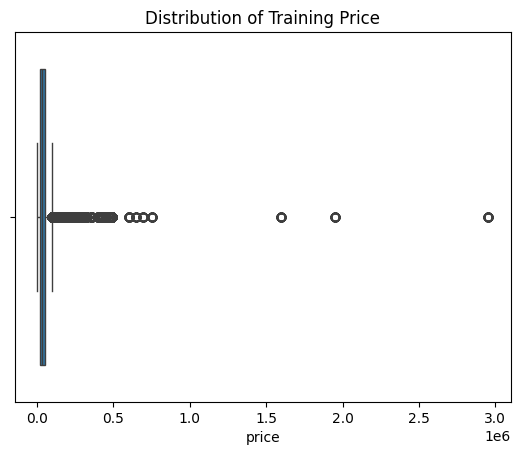

In [224]:
sns.boxplot(x=df['price'])
plt.title("Distribution of Training Price")
plt.show()

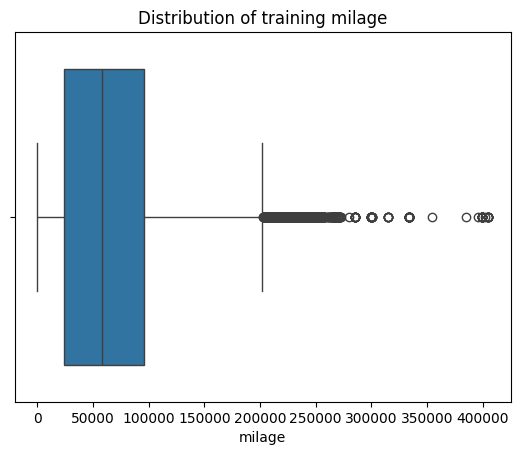

In [225]:
sns.boxplot(x=df['milage'])
plt.title("Distribution of training milage")
plt.show()

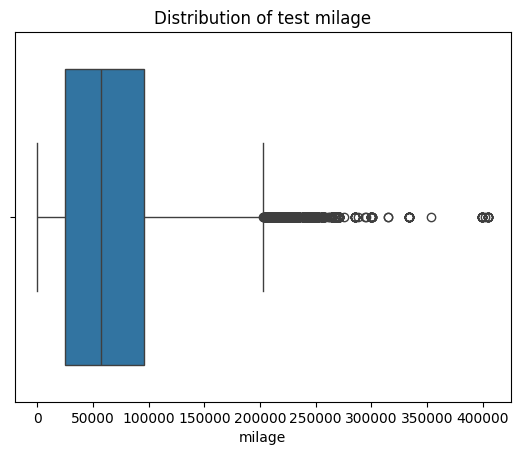

In [226]:
sns.boxplot(x=test['milage'])
plt.title("Distribution of test milage")
plt.show()

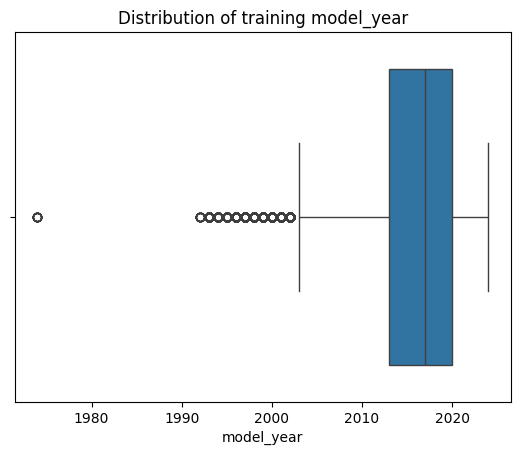

In [227]:
sns.boxplot(x=df['model_year'])
plt.title("Distribution of training model_year")
plt.show()

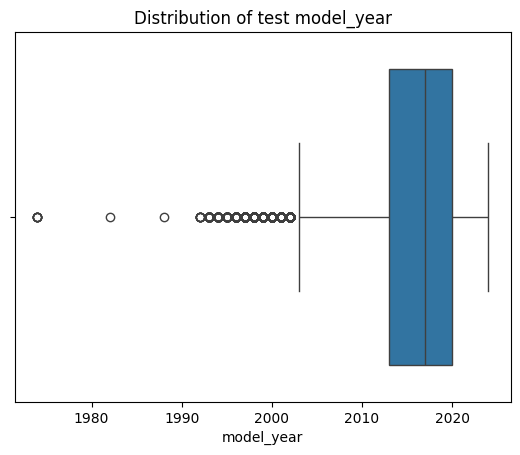

In [228]:
sns.boxplot(x=test['model_year'])
plt.title("Distribution of test model_year")
plt.show()

It seems price and milage has extreme outliers.

In [229]:
df['price'].describe()

,price
count,1.885330e+05
mean,4.387802e+04
std,7.881952e+04
min,2.000000e+03
25%,1.700000e+04
50%,3.082500e+04
75%,4.990000e+04
max,2.954083e+06


In [230]:
df['milage'].describe()

,milage
count,188533.000000
mean,65705.295174
std,49798.158076
min,100.000000
25%,24115.000000
50%,57785.000000
75%,95400.000000
max,405000.000000


In [231]:
def handle_outliers(col, limit=2):
    '''
    Truncate outliers according to limit argument
    Truncate here means set values to 0

    Args:
    col (Series): Column to truncate
    limit (int) : Multiple of standard deviation at which to truncate column
    '''
    x = col.copy()
    mean = x.mean()
    std_dev = x.std()
    lower_bound = mean - (limit * std_dev)
    upper_bound = mean + (limit * std_dev)

    x[x < lower_bound] = lower_bound
    x[x > upper_bound] = upper_bound

    return x

In [232]:
df['price'] = handle_outliers(df['price'], 2)
df['milage'] = handle_outliers(df['milage'], 2)
df['model_year'] = handle_outliers(df['model_year'], 2)

test['milage'] = handle_outliers(test['milage'], 2)
test['model_year'] = handle_outliers(test['model_year'], 2)

<ipython-input-231-17bf7a5b4acc>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2004.5080633748582' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x[x < lower_bound] = lower_bound
<ipython-input-231-17bf7a5b4acc>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2004.4499324831122' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x[x < lower_bound] = lower_bound


After truncating outliers upto 2 * std dv, Let's see boxplot of resulting distribution of features.

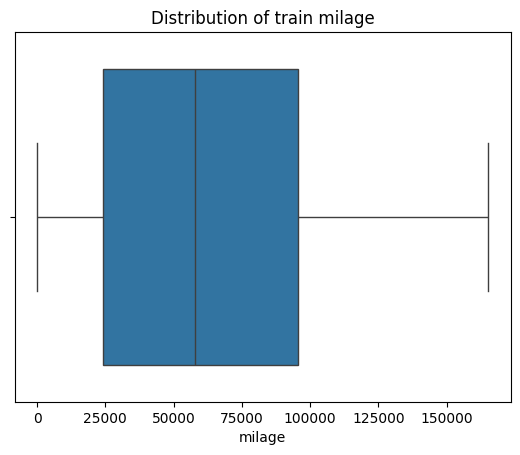

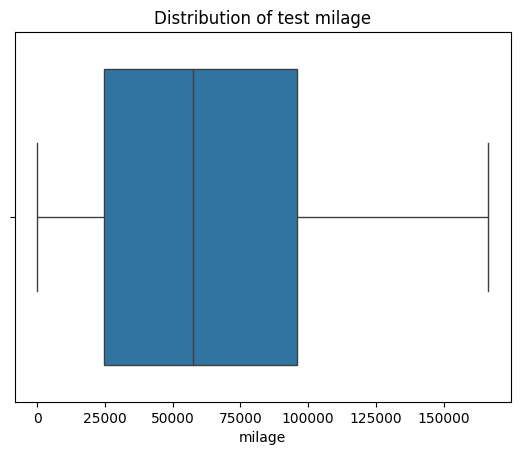

In [233]:
sns.boxplot(x=df['milage'])
plt.title("Distribution of train milage")
plt.show()
sns.boxplot(x=test['milage'])
plt.title("Distribution of test milage")
plt.show()

Visualize price and model_year outliers

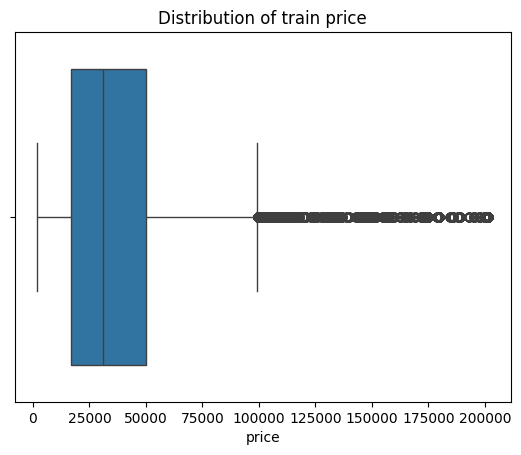

In [234]:
sns.boxplot(x=df['price'])
plt.title("Distribution of train price")
plt.show()

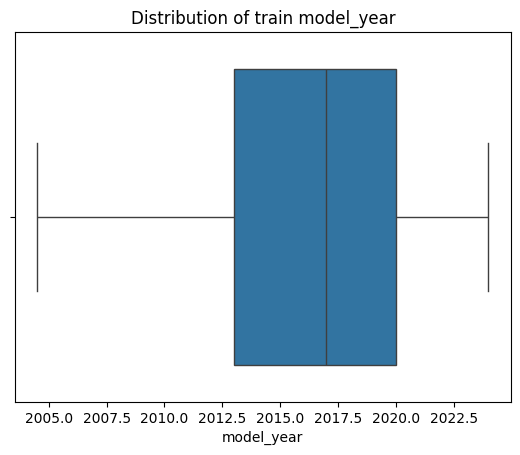

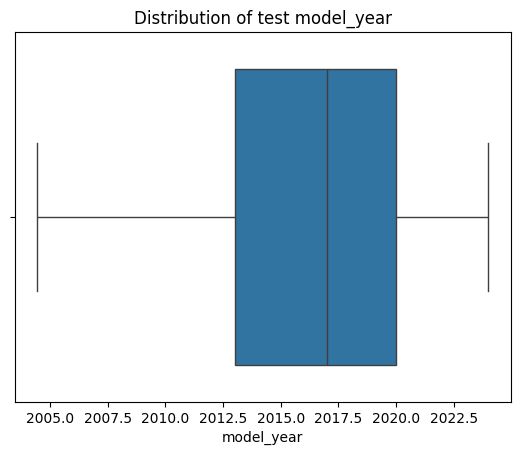

In [235]:
sns.boxplot(x=df['model_year'])
plt.title("Distribution of train model_year")
plt.show()

sns.boxplot(x=test['model_year'])
plt.title("Distribution of test model_year")
plt.show()

# Clean missing values

In [236]:
def check_null(df, test):
  ''' Returns DataFrame containg isnull() Series for both Train and Test set '''
  return pd.DataFrame({'train null' : df.isnull().sum(), 'test null': test.isnull().sum()})

In [237]:
# Check for missing values
check_null(df, test)

,train null,test null
accident,2452,1632.0
brand,0,0.0
clean_title,21419,14239.0
engine,0,0.0
ext_col,0,0.0
fuel_type,5083,3383.0
int_col,0,0.0
milage,0,0.0
model,0,0.0
model_year,0,0.0


In [238]:
# Cleans the categorical and continuos data for missing values using imputation
# try experimeting with median imputer for both continuos and categorical

class Cleaner():
    def __init__(self, df):
      self.df = df
      self.categoricals = []
      self.continuos = []
      self.categoricals_imputed = []
      self.continuos_imputed = []

      self.mean_imputer = SimpleImputer(strategy='mean')
      self.mode_imputer = SimpleImputer(strategy='most_frequent')

      self.update_vars()


    def update_vars(self, extra_categoricals=[], extra_continuos=[]):
        '''
        Updates list of categoricals and continuos variables based on dtypes
        Features with dtype int, object and category are considered categoricals while float features are considered continuos.

        Args:
        extra_categoricals (list): Non categorical features which are to be trated as categoricals
        extra_continuos (list) :  Non continuos features to be trated as continuos
        '''
        self.categoricals = list(set(self.categoricals) | set(self.df.select_dtypes(include=[int, object, 'category']).columns))

        if extra_categoricals:
            self.categoricals = list(set(self.categoricals) | set(extra_categoricals))

        self.continuos = [col for col in self.df.columns if col not in self.categoricals]
        if extra_continuos:
            self.continuos = list(set(self.continuos) | set(extra_continuos))


    def clean_categoricals(self):
        '''
        Cleans categorical features using Mode imputation
        '''
        self.update_vars()
        categorical_missing_vars = list(filter(lambda x: x not in self.categoricals_imputed, self.categoricals))

        if categorical_missing_vars:
          print(f'Categorical_missing_vars: {categorical_missing_vars}')
          self.df[categorical_missing_vars] = self.mode_imputer.fit_transform(self.df[categorical_missing_vars])
          self.categoricals_imputed += categorical_missing_vars


    def clean_continuos(self):
        self.update_vars()

        continuos_missing_vars = list(filter(lambda x: x not in self.continuos_imputed, self.continuos))

        if continuos_missing_vars:
          print(f'Continuos_missing_vars: {continuos_missing_vars}')
          self.df[continuos_missing_vars] = self.mean_imputer.fit_transform(self.df[continuos_missing_vars])
          self.continuos_imputed += continuos_missing_vars


In [239]:
cleaner = Cleaner(df = df)
test_cleaner = Cleaner(df = test)

In [240]:
cleaner.clean_categoricals()
test_cleaner.clean_categoricals()

Categorical_missing_vars: ['accident', 'int_col', 'engine', 'model', 'transmission', 'fuel_type', 'ext_col', 'clean_title', 'brand']
Categorical_missing_vars: ['accident', 'int_col', 'engine', 'model', 'transmission', 'fuel_type', 'ext_col', 'clean_title', 'brand']


In [241]:
check_null(df, test)

,train null,test null
accident,0,0.0
brand,0,0.0
clean_title,0,0.0
engine,0,0.0
ext_col,0,0.0
fuel_type,0,0.0
int_col,0,0.0
milage,0,0.0
model,0,0.0
model_year,0,0.0


In [242]:
# Categorical: Int, object: Won't be scaled and will be applied mode Imputer
# Continuos: Float, float64:  Will be Scaled, applied mean Imputer

# Feature Engineering

Functions to extract features from original dataset

In [243]:
# Categorical
def get_automatic(string):
    string = string.lower()
    if 'a/t' in string or 'automatic' in string or 'at' in string:
        return 1
    else:
        return 0

In [244]:
# Categorical
def get_gears(string):
    match = re.search(r'^(\d+)-Speed', string, re.IGNORECASE)
    if match:
        gears = match.group(1)
        return int(gears)
    else:
        return None

In [245]:
# Contiunuos
def get_hp(engine):
    match = re.search(r'([\d.]+)HP', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [246]:
# Continuos
def get_L(engine):
    match = re.search(r'([\d.]+)L', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [247]:
# Categorical
def get_cyl(engine):
    match = re.search(r'([\d.]+)?\s?(?:Cylinder|Cyl|Cylinders)', engine, re.IGNORECASE)
    if match:
      return int(match.group(1))
    else:
      return None

In [248]:
# Categorical
def is_electric(engine):
    if 'electric' in engine.lower():
      return 1
    else:
      return 0

In [249]:
# Continuos
def num_valves(engine):
    match = re.search(r'([\d+])V', engine)
    if match:
      return float(match.group(1))
    else:
      return None

In [250]:
# Categorical
def is_accident(accident):
    if type(accident) == str:
        if 'accident' in accident.lower():
          return 1
        else:
          return 0
    else:
        return None

In [251]:
# Create features and insert into dataframe

def create_features(df):
    ''' Extract features using defined functions
        Returns dataframe updated with newly created features '''

    df['automatic'] = df['transmission'].apply(get_automatic)
    df['gears'] = df['transmission'].apply(get_gears)
    df['hp'] = df['engine'].apply(get_hp)
    df['L'] = df['engine'].apply(get_L)
    df['cylinders'] = df['engine'].apply(get_cyl)
    df['accident'] = df['accident'].apply(is_accident)
    df['electric'] = df['engine'].apply(is_electric)
    df['valves'] = df['engine'].apply(num_valves)

def create_interactions(df):
    '''
    Creates mathematical combinations of features mostly based on intuition.
    Updates df with new features

    Args:
    df (DataFrame) : DataFrame to add new features
    '''

    df['hp/l'] = np.where(df['L'] != 0, df['hp'] / df['L'], None).astype('float')
    df['mil/l'] = np.where(df['L'] != 0, df['milage'] / df['L'], None).astype('float')
    df['mil/hp'] = np.where(df['hp'] != 0, df['milage'] / df['hp'], None).astype('float')
    df['l/cyl'] = np.where(df['cylinders'] != 0, df['L'] / df['cylinders'], None).astype('float')
    df['hp/gears'] = np.where(df['gears'] != 0, df['hp'] / df['gears'], None).astype('float')
    df['mil/gears'] = np.where(df['gears'] != 0, df['milage'] / df['gears'], None).astype('float')
    df['mil/cyl'] = np.where(df['cylinders'] != 0, df['milage'] / df['cylinders'], None).astype('float')

    df['hp*automatic'] = df['hp'] * df['automatic']
    df['cyl*gears'] = df['cylinders'] * df['gears']

    df['carAge'] = pd.Series(2024 - df['model_year']).astype('int')
    df['mil/year'] = np.where(df['carAge'] != 0, df['milage'] / df['carAge'], None).astype('float')
    df['hp*accident'] = pd.Series(df['hp'] * df['accident']).astype('float')
    df['accident*carAge'] = pd.Series(df['accident'] * df['carAge']).astype('float')
    df['acc*milage'] = pd.Series(df['accident'] * df['milage']).astype('float')

    df['mil*carAge'] = pd.Series(df['milage'] * df['carAge']).astype('float')
    df['hp*mil'] = pd.Series(df['hp'] * df['milage']).astype('float')


In [252]:
create_features(df)
create_features(test)

We'll treat L, cylinders, gears features as categoricals as their unique values are less.

### Clean newly created features

In [253]:
# We will treat some suitable variables as categorical
cleaner.update_vars(extra_categoricals = ['L', 'cylinders', 'gears'])
test_cleaner.update_vars(extra_categoricals = ['L', 'cylinders', 'gears'])

In [254]:
cleaner.clean_categoricals()
cleaner.clean_continuos()

test_cleaner.clean_categoricals()
test_cleaner.clean_continuos()

Categorical_missing_vars: ['gears', 'L', 'electric', 'automatic', 'cylinders']
Continuos_missing_vars: ['model_year', 'milage', 'price', 'hp', 'valves']
Categorical_missing_vars: ['gears', 'L', 'electric', 'automatic', 'cylinders']
Continuos_missing_vars: ['model_year', 'milage', 'hp', 'valves']


In [255]:
check_null(df, test)

,train null,test null
L,0,0.0
accident,0,0.0
automatic,0,0.0
brand,0,0.0
clean_title,0,0.0
cylinders,0,0.0
electric,0,0.0
engine,0,0.0
ext_col,0,0.0
fuel_type,0,0.0


### Create Interaction features

In [256]:
# Create interaction features
create_interactions(df)
create_interactions(test)

In [257]:
cleaner.update_vars()
test_cleaner.update_vars()

non_impute_cols = [col for col in df.columns if col in cleaner.continuos and col not in cleaner.continuos_imputed]

for col in non_impute_cols:
  df[col] =  handle_outliers(df[col], 3)
  test[col] = handle_outliers(test[col], 3)

In [258]:
cleaner.clean_continuos()
test_cleaner.clean_continuos()

Continuos_missing_vars: ['hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil']
Continuos_missing_vars: ['hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil']


Some features might have skewed distributions, specifically righly skewed distribution. These can be log transformed to make them go near normal distribution.

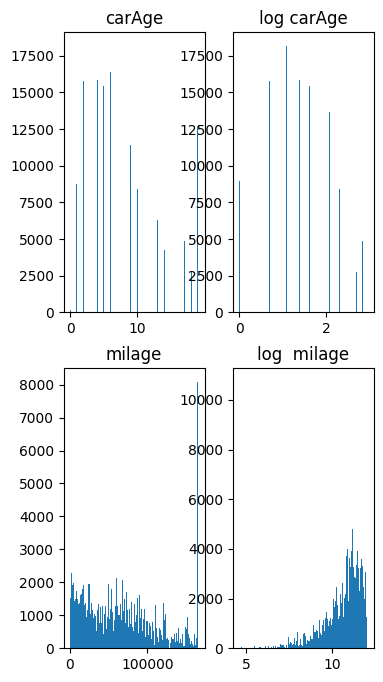

In [259]:
# Some features with rightly skewed data can be log transformed
fig, axs = plt.subplots(2, 2, figsize=(4, 8))

# carAge distribution
axs[0, 0].hist(df['carAge'], bins=200)
axs[0, 0].set_title('carAge')

axs[1, 0].hist(df['milage'], bins=200)
axs[1, 0].set_title('milage')

# milage is right skewed. Log transformation could be used.
carAge = np.where(df['carAge'] != 0, df['carAge'], 1).astype('float')
milage = np.where(df['milage'] != 0, df['milage'], 1).astype('float')

log_carAge = np.log(carAge)
log_milage = np.log(milage)

axs[0, 1].hist(log_carAge, bins=200)
axs[0, 1].set_title('log carAge')

axs[1,1].hist(log_milage, bins=200,)
axs[1,1].set_title('log  milage')
plt.show()

log transformation will be applied in later function.

#### Add binning to milage

In [260]:
# Get range of values
print(f'min: {np.min(milage)}, max:{np.max(milage)}')

min: 100.0, max:165301.61132529768


In [261]:
# Add binning to milage and categorize ordinally
bins = [99.0, 300.0, 700.0, 1000.0, 3000.0, 7000., 10000.0, 20000., 35000., 50000.0, 75000, 100000.0, 125000.0, 150000., 175000, 200000.0, 250000.0]
intervals = {pd.Interval(bins[i], bins[i+1], closed='left') : i for i in range(len(bins) - 1)}

train_binned_milage = pd.cut(df['milage'], bins, right=False)
test_binned_milage = pd.cut(test['milage'], bins, right=False)

df['binned_milage'] = train_binned_milage.map(lambda x: intervals[x])
test['binned_milage'] = test_binned_milage.map(lambda x: intervals[x])

Assign classes to brands according to their mean prices

In [262]:
# Get range of values
print(np.min(df['price']), np.max(df['price']))

2000.0 201517.06068646687


In [263]:
# Classes will be ordinally categorized

# Define bins
bins = [1000.0, 5000.0, 10000.0, 25000.0, 50000.0, 75000., 100000.0, 125000., 150000.0, 175000., 200000.0, 225000., 250000.0, 275000.0, 300000.0]

binned_prices = pd.cut(df['price'], bins, right=False)

# Create interval mapping
intervals = {pd.Interval(bins[i], bins[i+1], closed='left'): i for i in range(len(bins) - 1)}

brand_avg_price = df.groupby('brand')['price'].mean().to_dict()   # {'brand_name' : mean_price}

def get_class(mean_price):
    for interval, class_ in intervals.items():
        if mean_price in interval:
          return class_

df['brand_class'] = df['brand'].map(lambda x: get_class(brand_avg_price[x]))
test['brand_class'] = test['brand'].map(lambda x: get_class(brand_avg_price[x]))


In [264]:
def additional_features(df):
    df['AverageMilage'] = df.groupby("brand")['milage'].transform('mean')
    df['BrandFreq'] = df.groupby('brand')['brand'].transform('count')/df['brand'].count()

    brand_count = df.groupby('brand')['brand'].count().to_dict()
    df['brand_count'] = df['brand'].map(brand_count)

    brand_avg_mil = df.groupby('brand')['milage'].mean().to_dict()
    df['brand_avg_mil'] = df['brand'].map(brand_avg_mil)

    df['log_milage'] = np.log(df['milage'])

    df['logL'] = np.log(df['L'])

    df['logAge'] = np.log1p(df['carAge'])


In [265]:
additional_features(df)
additional_features(test)

In [266]:
cleaner.update_vars()
test_cleaner.update_vars()

non_impute_cols = [col for col in df.columns if col in cleaner.continuos and col not in cleaner.continuos_imputed]

for col in non_impute_cols:
  df[col] =  handle_outliers(df[col], 3)
  test[col] = handle_outliers(test[col], 3)

In [267]:
check_null(df, test)

,train null,test null
AverageMilage,0,0.0
BrandFreq,0,0.0
L,0,0.0
acc*milage,0,0.0
accident,0,0.0
accident*carAge,0,0.0
automatic,0,0.0
binned_milage,0,0.0
brand,0,0.0
brand_avg_mil,0,0.0


In [268]:
cleaner.clean_continuos()
test_cleaner.clean_continuos()

Continuos_missing_vars: ['AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge']
Continuos_missing_vars: ['AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge']


## Label encode categoricals

In [269]:
# Label categorical features
for colname in cleaner.categoricals:
    df[colname], _ = df[colname].factorize()

for colname in test_cleaner.categoricals:
    test[colname], _ = test[colname].factorize()

In [270]:
X = df.copy()
y = X.pop('price')

In [271]:
X.shape, y.shape

((188533, 43), (188533,))

In [272]:
test.shape

(125690, 43)

#### PCA

In [273]:
# Standardize the data (important for PCA)
X_pca = X.copy()
test_pca = test.copy()

scaler_pca = StandardScaler()

X_pca[X_pca.select_dtypes(include='float').columns] = scaler_pca.fit_transform(X_pca.select_dtypes(include='float'))
test_pca[X_pca.select_dtypes(include='float').columns] = scaler_pca.fit_transform(test_pca.select_dtypes(include='float'))
print(X_pca.select_dtypes(include='float').columns)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
X_pca_components = pca.fit_transform(X_pca)
test_pca_components = pca.fit_transform(test_pca)

# Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print("Explained Variance Ratio:", explained_variance)

# Convert to DataFrame for better readability
pca_df = pd.DataFrame(data=X_pca_components, columns=['PC1', 'PC2'])
X = pd.concat([X, pca_df], axis=1)

pca_df = pd.DataFrame(data=test_pca_components, columns=['PC1', 'PC2'])
test = pd.concat([test, pca_df], axis=1)

Index(['model_year', 'milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp',
       'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic',
       'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage',
       'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil',
       'log_milage', 'logL', 'logAge'],
      dtype='object')
Explained Variance Ratio: 0.992004730676758


In [274]:
cleaner.categoricals.extend(['PC1', 'PC2'])
test_cleaner.categoricals.extend(['PC1', 'PC2'])

In [275]:
# See loadings

# Get the principal components (PCs)
components = pca.components_
print(components.shape)

# Create a DataFrame for easy visualization
components_df = pd.DataFrame(components, columns=X_pca.columns, index=['PC1', 'PC2'])

# Display the loadings (contributions of each feature to each component)
components_df

(2, 43)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,hp*mil,binned_milage,brand_class,AverageMilage,BrandFreq,brand_count,brand_avg_mil,log_milage,logL,logAge
PC1,0.006061,0.972764,-0.000082,0.000035,0.000117,0.231487,0.000563,0.007673,0.001991,0.000029,...,-0.000102,0.000188,0.000219,0.000077,-0.000579,0.006061,0.000077,-0.000010,-0.000287,0.000034
PC2,0.003505,-0.231482,-0.000793,0.000418,0.000378,0.972739,0.001848,-0.008459,-0.001268,0.000069,...,0.000308,0.000442,0.000538,0.000139,-0.000199,0.003505,0.000139,0.000228,0.000177,0.000644


Create features inspired by results of PCA

In [276]:
mo_en = np.where(X['engine'] != 0, X['model'] / X['engine'], 0)

Calculate mutual informtion score to see feature is significant

In [277]:
bf_en = X['BrandFreq'] * X['engine']
bf_en_mi = mutual_info_regression(pd.DataFrame(bf_en), y)

In [278]:
bf_en_mi

array([0.42409269])

Add feature to dataset

In [279]:
X['bf_en'] = bf_en
test['bf_en'] = test['BrandFreq'] * test['engine']

#### K-means Clustering

In [280]:
# Add cluster feature
c_scaler = StandardScaler()

kmeans = KMeans(n_clusters=3, n_init=10)

XC = [col for col in X.columns if col not in cleaner.categoricals]
XC = X[XC]
XC = c_scaler.fit_transform(XC)
X['Cluster'] = kmeans.fit_predict(XC)
X['Cluster'] = X['Cluster'].astype('int')

test_conts = [col for col in test.columns if col not in test_cleaner.categoricals]
test_conts = test[test_conts]
test_conts = c_scaler.transform(test_conts)
test['Cluster'] = kmeans.fit_predict(test_conts)
test['Cluster'] = test['Cluster'].astype('int')

In [281]:
cleaner.categoricals.extend(['Cluster'])
test_cleaner.categoricals.extend(['Cluster'])

#### Output of a trained Ridge model as a feature

In [282]:
r_model = Ridge(alpha=1)
r_model.fit(X, y)

print(f'train error: {np.sqrt(mean_squared_error(r_model.predict(X), y))}')

X['r_predict'] = r_model.predict(X)
test['r_predict'] = r_model.predict(test)

train error: 27137.776003415176


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.29552e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# One Hot encoding

In [283]:
'''cols = ['model', 'fuel_type', 'brand', 'int_col', 'ext_col', 'transmission', 'brand_class', 'Cluster',]

# One-hot encoding
encoded_data = pd.get_dummies(X[cols].astype('str'))
X = pd.concat([X, encoded_data], axis=1)

# Remove original encoded features
X = X.drop(cols, axis=1)

# Update categoricals list in cleaner
cleaner.categoricals = [col for col in cleaner.categoricals if col not in cols]
cleaner.categoricals.extend(encoded_data.columns.tolist())
len(cleaner.categoricals)'''

"cols = ['model', 'fuel_type', 'brand', 'int_col', 'ext_col', 'transmission', 'brand_class', 'Cluster',]\n\n# One-hot encoding\nencoded_data = pd.get_dummies(X[cols].astype('str'))\nX = pd.concat([X, encoded_data], axis=1)\n\n# Remove original encoded features\nX = X.drop(cols, axis=1)\n\n# Update categoricals list in cleaner\ncleaner.categoricals = [col for col in cleaner.categoricals if col not in cols]\ncleaner.categoricals.extend(encoded_data.columns.tolist())\nlen(cleaner.categoricals)"

one hot encoding didn't showed much improvement.so we drop it.

In [284]:
check_null(X, test)

,train null,test null
brand,0,0
model,0,0
model_year,0,0
milage,0,0
fuel_type,0,0
engine,0,0
transmission,0,0
ext_col,0,0
int_col,0,0
accident,0,0


# Split the data

Below features are selected using mutual_info_regression and RFE, both of sklearn library.

In [285]:
selected_features = ['bf_en', 'milage', 'log_milage', 'engine', 'mil*carAge', 'mil/cyl', 'mil/gears', 'hp/l', 'mil/hp', 'carAge', 'model_year', 'hp', 'logAge', 'PC1', 'hp/gears', 'r_predict', 'brand', 'model_year', 'milage', 'engine', 'transmission', 'ext_col', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'mil/gears', 'mil*carAge', 'AverageMilage', 'BrandFreq', 'brand_class', 'logAge', 'PC1', 'PC2', 'r_predict']

In [286]:
X_split = X[selected_features]
test = test[selected_features]

In [287]:
X_train, X_, y_train, y_ = train_test_split(X_split, y, test_size=0.2, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

(150826, 36) (18854, 36)


# Standardize the data
Standardize only contunios features.

In [288]:
# Scale train continuos features
continuos_features_to_scale = [col for col in X.columns if col not in cleaner.categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

scalerTrain = StandardScaler()
X[continuos_features_to_scale] = scalerTrain.fit_transform(X[continuos_features_to_scale])
test[continuos_features_to_scale] = scalerTrain.transform(test[continuos_features_to_scale])

Features to be scaled: ['model_year', 'milage', 'hp', 'valves', 'hp/l', 'mil/l', 'mil/hp', 'l/cyl', 'hp/gears', 'mil/gears', 'mil/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'mil*carAge', 'hp*mil', 'AverageMilage', 'BrandFreq', 'brand_avg_mil', 'log_milage', 'logL', 'logAge', 'bf_en', 'r_predict']


KeyError: "['l/cyl', 'hp*automatic', 'cyl*gears', 'mil/year', 'hp*accident', 'accident*carAge', 'acc*milage', 'hp*mil', 'brand_avg_mil', 'logL'] not in index"

# Model Training

### TensorFlow Neural Network

In [289]:
'''# Define a custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))'''

'# Define a custom RMSE metric\ndef rmse(y_true, y_pred):\n    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))'

In [192]:
'''model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, 'relu', kernel_regularizer=tf.keras.regularizers.L2(2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[rmse])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)'''

"model = tf.keras.models.Sequential([\n    tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(2)),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(3, 'relu', kernel_regularizer=tf.keras.regularizers.L2(2)),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(1),\n])\n\nmodel.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[rmse])\n\nhistory = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)"

In [193]:
'''t_loss = np.sqrt(history.history['loss'])
v_loss = np.sqrt(history.history['val_loss'])
plt.plot(t_loss, c='r', label='train loss')
plt.plot(v_loss, c='b', label='validation loss')
plt.title('Train/Validation MSEs')
plt.legend()
plt.show()'''

"t_loss = np.sqrt(history.history['loss'])\nv_loss = np.sqrt(history.history['val_loss'])\nplt.plot(t_loss, c='r', label='train loss')\nplt.plot(v_loss, c='b', label='validation loss')\nplt.title('Train/Validation MSEs')\nplt.legend()\nplt.show()"

In [194]:
'''test_loss = model.evaluate(X_test, y_test)
print(f'Test RMSE Loss: {np.sqrt(test_loss)}')'''

"test_loss = model.evaluate(X_test, y_test)\nprint(f'Test RMSE Loss: {np.sqrt(test_loss)}')"

### XGB Regressor Model

In [290]:
x_train = X_train.values
y_train = y_train.values
x_cv = X_val.values
y_cv = y_val.values
x_test = X_test.values
y_test = y_test.values
test = test.values

# Hyperparameters Search

In [197]:
'''from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),         # Number of trees
    'max_depth': np.arange(3, 10),                     # Tree depth
    'learning_rate': np.linspace(0.01, 0.3, 10),       # Learning rate (eta)
    'subsample': np.linspace(0.5, 1.0, 5),             # Subsample ratio
    'colsample_bytree': np.linspace(0.5, 1.0, 5),      # Column subsampling
    'gamma': np.linspace(0, 5, 10),                    # Minimum loss reduction
    'alpha': np.linspace(0, 1, 10),                    # L1 regularization
    'lambda': np.linspace(0, 1, 10)                    # L2 regularization
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of random combinations to try
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=3,                      # 3-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Reproducibility
    n_jobs=-1,
)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
'''

'from sklearn.model_selection import RandomizedSearchCV\n\n# Define the parameter grid\nparam_distributions = {\n    \'n_estimators\': np.arange(100, 1000, 100),         # Number of trees\n    \'max_depth\': np.arange(3, 10),                     # Tree depth\n    \'learning_rate\': np.linspace(0.01, 0.3, 10),       # Learning rate (eta)\n    \'subsample\': np.linspace(0.5, 1.0, 5),             # Subsample ratio\n    \'colsample_bytree\': np.linspace(0.5, 1.0, 5),      # Column subsampling\n    \'gamma\': np.linspace(0, 5, 10),                    # Minimum loss reduction\n    \'alpha\': np.linspace(0, 1, 10),                    # L1 regularization\n    \'lambda\': np.linspace(0, 1, 10)                    # L2 regularization\n}\n\n# Initialize RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    estimator=xgb_model,\n    param_distributions=param_distributions,\n    n_iter=50,                 # Number of random combinations to try\n    scoring=\'neg_mean_squared_error\',  # Evalu

Obtained by running RandomSearchCV for 23 mins with t4 gpu
```python  
best_parameters= {'subsample': 0.875,
                  'n_estimators': 900,
                  'max_depth': 7,
                  'learning_rate': 0.042222222222222223,
                  'lambda': 100.0,
                  'gamma': 1.6666666666666667,
                  'colsample_bytree': 0.3,
                  'alpha': 0.4444444444444444,
                  'subsample': 0.3,
                  'alpha':100,
                  'min_child_weight':10,
                     }
```                     


# Manual Hyperparameter tuning

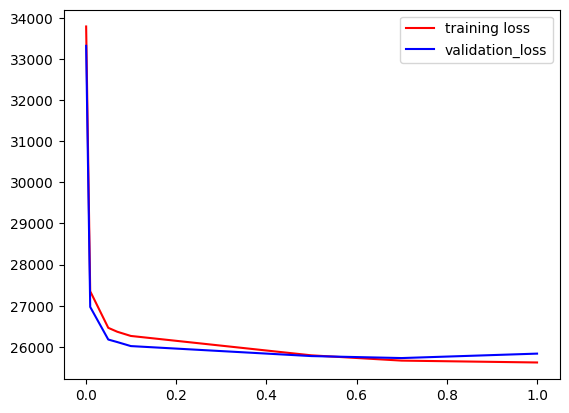

In [198]:
rates = [0.001, 0.01, 0.05, 0.07, 0.1, 0.5, 0.7, 1.0]
cv = []
tr = []

for rate in rates:
    xgb_model = XGBRegressor(learning_rate= rate,
                        max_depth = 2,
                        n_estimators = 200,
                        enable_categorical=True,
                     )

    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))

plt.plot(rates, tr, c='r', label='training loss')
plt.plot(rates, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [199]:
optimum_lrate = rates[np.argmin(cv)]
optimum_lrate

0.7

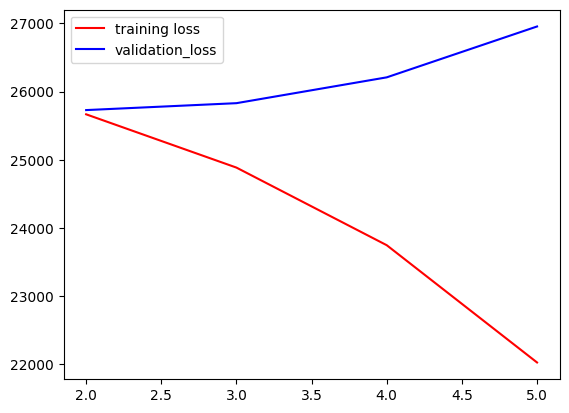

In [200]:
depths = [2, 3, 4, 5]
cv = []
tr = []

for depth in depths:
    xgb_model = XGBRegressor(learning_rate= optimum_lrate,
                        max_depth = depth,
                        n_estimators = 200,
                        enable_categorical=True,
                     )
    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))

plt.plot(depths, tr, c='r', label='training loss')
plt.plot(depths, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [201]:
optimum_depth = depths[np.argmin(cv)]
optimum_depth

2

In [202]:
subsamples = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cv = []
tr = []

for fraction in subsamples:
    xgb_model = XGBRegressor(learning_rate= optimum_lrate,
                        max_depth = optimum_depth,
                        n_estimators = 200,
                        enable_categorical=True,
                        subsample= fraction,
                     )

    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))


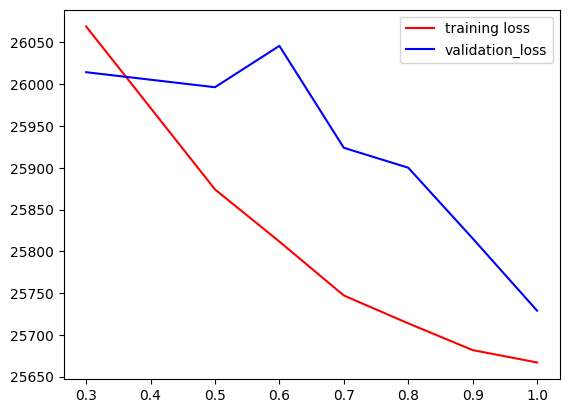

In [203]:
plt.plot(subsamples, tr, c='r', label='training loss')
plt.plot(subsamples, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [204]:
optimum_subsample = subsamples[np.argmin(cv)]
optimum_subsample

1.0

In [205]:
lambdas = [0.001, 0.05, 0.1, 0.5, 0.7, 1.0, 3.0, 7., 10., 20.]
cv = []
tr = []

for lambd in lambdas:
    xgb_model = XGBRegressor(learning_rate= optimum_lrate,
                        max_depth = optimum_depth,
                        n_estimators = 200,
                        enable_categorical=True,
                        subsample= optimum_subsample,
                        reg_lambda=lambd
                     )

    xgb_model.fit(x_train, y_train)
    ypred = xgb_model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    tr.append(np.sqrt(xgb_train_mse))

    ypred = xgb_model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    cv.append(np.sqrt(xgb_cv_mse))


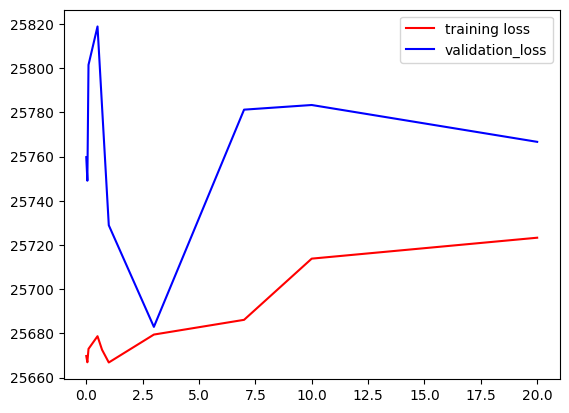

In [206]:
plt.plot(lambdas, tr, c='r', label='training loss')
plt.plot(lambdas, cv, c='b', label='validation_loss')
plt.legend()
plt.show()

In [207]:
optimum_lambda = lambdas[np.argmin(cv)]
optimum_lambda

3.0

# Final Model

In [291]:
xgb_model = XGBRegressor(learning_rate= optimum_lrate,
                        max_depth = optimum_depth,
                        n_estimators = 200,
                        enable_categorical=True,
                        subsample = optimum_subsample,
                        reg_lambda = optimum_lambda
                     )

In [292]:
# Train model
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.7, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [293]:
# Calculate RMSE
ypred = xgb_model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)

print(f'Train RMSE: {np.sqrt(xgb_train_mse)}')

Train RMSE: 25704.164610268817


In [294]:
ypred = xgb_model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)
xgb_train_mse = np.sqrt(xgb_train_mse)

ypred = xgb_model.predict(x_cv)
xgb_cv_mse = mean_squared_error(y_cv, ypred)
xgb_cv_mse = np.sqrt(xgb_cv_mse)


print(f'train RMSE: {xgb_train_mse}\nValidation RMSE: {xgb_cv_mse}')
print(f'Difference: {abs(xgb_train_mse - xgb_cv_mse):.4f}')

train RMSE: 25704.164610268817
Validation RMSE: 25615.60843198624
Difference: 88.5562


In [295]:
y_pred = xgb_model.predict(x_test)
test_error = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_error)
print(f'test RMSE: {test_rmse}')

test RMSE: 26072.357179705163


Visualize distribution of training targets, predicted targets and test targets.

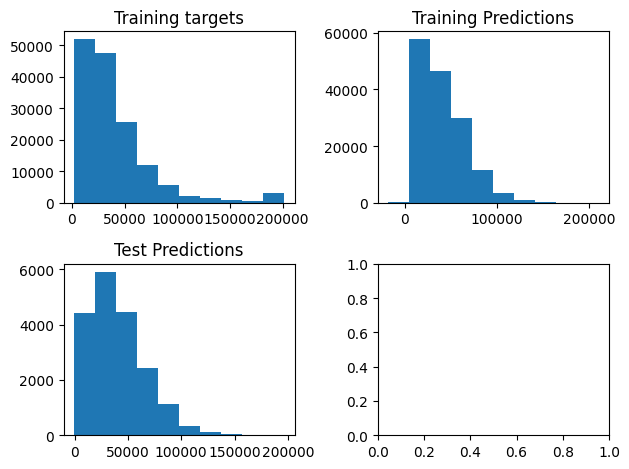

In [296]:
train_pred = xgb_model.predict(x_train)
test_pred = xgb_model.predict(x_test)

fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(y_train)
axs[0, 0].set_title('Training targets')

axs[0, 1].hist(train_pred)
axs[0, 1].set_title('Training Predictions')

axs[1, 0].hist(y_pred)
axs[1, 0].set_title('Test Predictions')

plt.tight_layout()
plt.show()

### Submission

In [300]:
pred = xgb_model.predict(test)

In [301]:
submision = pd.DataFrame({'id': id, 'price': pred})

In [302]:
submision.to_csv('submission.csv', index=False)

Visualize distribution of training targets, their predicted targets and
test data predictions.

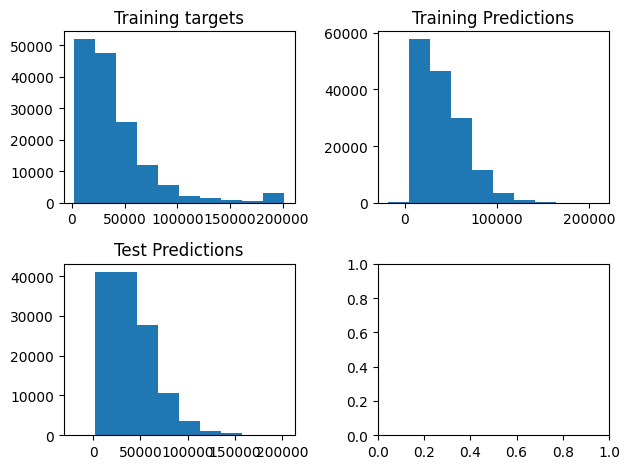

In [305]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(y_train)
axs[0, 0].set_title('Training targets')

axs[0, 1].hist(train_pred)
axs[0, 1].set_title('Training Predictions')

axs[1, 0].hist(pred)
axs[1, 0].set_title('Test Predictions')

plt.tight_layout()
plt.show()

Thus train an test data came from same distribution.

### Thank you.